# Branch 2: Anomaly Detection Analysis

This notebook focuses on:
- Statistical anomaly detection in traffic patterns
- Time-series analysis of request volumes
- IP behavior profiling and anomaly detection
- Error spike detection and correlation
- Machine learning-based outlier detection

**Analysis Branch:** Statistical & ML-based Anomaly Detection

## 1. Import Libraries and Setup

In [9]:
# Import required libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Add parent directory to path
sys.path.append('..')

# Import custom modules
from log_threat_detection.dataset import LogDataset
from log_threat_detection.models import AnomalyDetector
from log_threat_detection.config import *

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

print('✓ Libraries imported successfully')

✓ Libraries imported successfully


## 2. Load and Preprocess Data

In [10]:
# Initialize dataset loader
dataset = LogDataset()

# Load access and error logs
access_df, error_df = dataset.load_all()

# Preprocess logs
access_df = dataset.preprocess_access_log(access_df)
error_df = dataset.preprocess_error_log(error_df)

print('=' * 80)
print('DATA LOADING SUMMARY')
print('=' * 80)
print(f'Access Log Shape: {access_df.shape}')
print(f'Error Log Shape: {error_df.shape}')
print(f'\nAccess Log Date Range:')
if 'timestamp' in access_df.columns:
    print(f'  From: {access_df["timestamp"].min()}')
    print(f'  To: {access_df["timestamp"].max()}')

Loaded 233930 access log entries
Loaded 5075 error log entries
DATA LOADING SUMMARY
Access Log Shape: (233930, 13)
Error Log Shape: (5075, 10)

Access Log Date Range:
  From: 2025-02-28 00:00:02+05:30
  To: 2025-02-28 13:34:46+05:30


## 3. Traffic Anomaly Detection

In [11]:
# Initialize anomaly detector
anomaly_detector = AnomalyDetector()

# Detect traffic anomalies
traffic_anomalies = anomaly_detector.detect_traffic_anomalies(access_df)

print('=' * 80)
print('TRAFFIC ANOMALY DETECTION')
print('=' * 80)
print(f'Total Time Periods: {len(traffic_anomalies)}')
print(f'Anomalous Periods: {traffic_anomalies["is_anomaly"].sum()}')
print(f'Anomaly Rate: {traffic_anomalies["is_anomaly"].sum() / len(traffic_anomalies) * 100:.2f}%')
print(f'\nTop 5 Anomalous Periods:')
print(traffic_anomalies[traffic_anomalies['is_anomaly']].nlargest(5, 'request_count'))

TRAFFIC ANOMALY DETECTION
Total Time Periods: 14
Anomalous Periods: 1
Anomaly Rate: 7.14%

Top 5 Anomalous Periods:
                   timestamp  request_count   z_score  is_anomaly
12 2025-02-28 12:00:00+05:30          55422  2.187759        True


## 4. IP Behavior Profiling

In [12]:
# Profile IP behavior
ip_anomalies = anomaly_detector.detect_ip_anomalies(access_df)

# anomaly_score: -1 = anomaly, 1 = normal
ip_anomalies['is_anomaly'] = ip_anomalies['anomaly_score'] == -1

print('=' * 80)
print('IP BEHAVIOR ANOMALY DETECTION')
print('=' * 80)
print(f'Total IPs: {len(ip_anomalies)}')
print(f'Anomalous IPs: {ip_anomalies["is_anomaly"].sum()}')
print(f'Anomaly Rate: {ip_anomalies["is_anomaly"].sum() / len(ip_anomalies) * 100:.2f}%')
print(f'\nTop 10 Anomalous IPs:')
print(ip_anomalies[ip_anomalies['is_anomaly']].nlargest(10, 'request_count')[['request_count', 'error_rate', 'unique_paths']])

IP BEHAVIOR ANOMALY DETECTION
Total IPs: 5659
Anomalous IPs: 281
Anomaly Rate: 4.97%

Top 10 Anomalous IPs:
      request_count  error_rate  unique_paths
4040           2827    0.000000          1327
3287           1996    0.440882           115
905            1724    0.000000           275
45             1428    0.000000           235
677            1394    0.000000           236
2369           1364    0.000000           211
3812           1360    0.000000           229
40             1302    0.000000           260
125            1236    0.000000           149
409            1236    0.000000           230


## 5. Isolation Forest ML Model

In [13]:
# Apply Isolation Forest for anomaly detection
ip_features = ip_anomalies[['request_count', 'error_rate', 'unique_paths']].fillna(0)

# Standardize features
scaler = StandardScaler()
ip_features_scaled = scaler.fit_transform(ip_features)

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
predictions = iso_forest.fit_predict(ip_features_scaled)

# Add predictions to dataframe
ip_anomalies['ml_anomaly'] = predictions == -1

print('=' * 80)
print('ISOLATION FOREST RESULTS')
print('=' * 80)
print(f'Anomalies Detected: {(predictions == -1).sum()}')
print(f'Normal Behavior: {(predictions == 1).sum()}')
print(f'\nML-Detected Anomalous IPs:')
print(ip_anomalies[ip_anomalies['ml_anomaly']].nlargest(10, 'request_count')[['request_count', 'error_rate', 'unique_paths']])

ISOLATION FOREST RESULTS
Anomalies Detected: 283
Normal Behavior: 5376

ML-Detected Anomalous IPs:
      request_count  error_rate  unique_paths
4040           2827    0.000000          1327
3287           1996    0.440882           115
905            1724    0.000000           275
45             1428    0.000000           235
677            1394    0.000000           236
2369           1364    0.000000           211
3812           1360    0.000000           229
40             1302    0.000000           260
125            1236    0.000000           149
409            1236    0.000000           230


## 6. Error Spike Detection

In [14]:
# Detect error spikes
error_spikes = anomaly_detector.detect_error_spikes(access_df)

print('=' * 80)
print('ERROR SPIKE DETECTION')
print('=' * 80)
print(f'Total Time Periods: {len(error_spikes)}')
print(f'Periods with Error Spikes: {error_spikes["is_spike"].sum()}')
print(f'Spike Rate: {error_spikes["is_spike"].sum() / len(error_spikes) * 100:.2f}%')
print(f'\nTop 5 Error Spike Periods:')
print(error_spikes[error_spikes['is_spike']].nlargest(5, 'error_count'))

ERROR SPIKE DETECTION
Total Time Periods: 14
Periods with Error Spikes: 1
Spike Rate: 7.14%

Top 5 Error Spike Periods:
                   timestamp  error_count   z_score  is_spike
12 2025-02-28 12:00:00+05:30        55422  2.187759      True


## 7. Visualization: Anomaly Overview

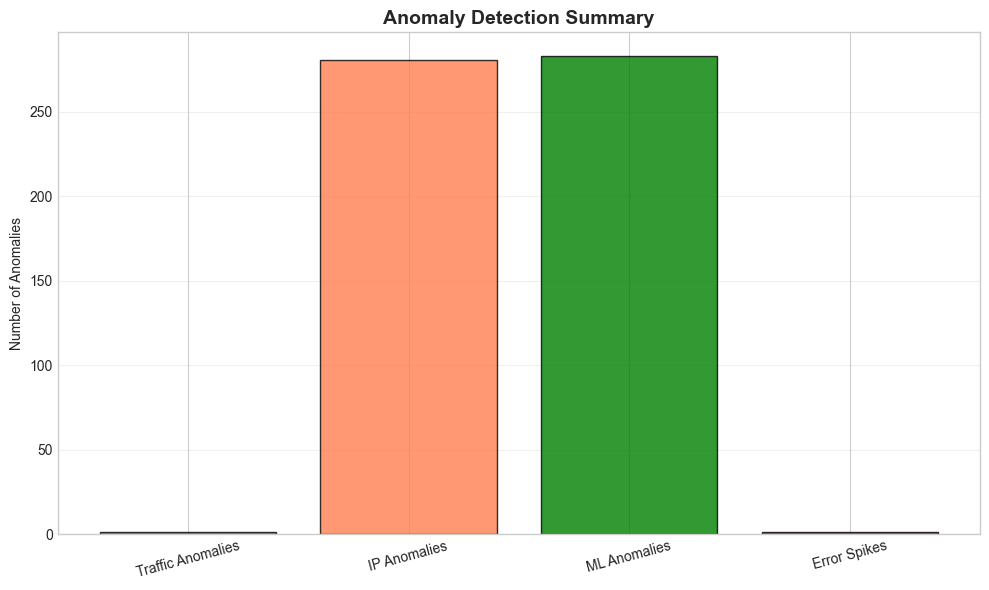

In [15]:
# Visualize anomaly summary
anomaly_summary = pd.DataFrame({
    'Type': ['Traffic Anomalies', 'IP Anomalies', 'ML Anomalies', 'Error Spikes'],
    'Count': [
        traffic_anomalies['is_anomaly'].sum(),
        ip_anomalies['is_anomaly'].sum(),
        ip_anomalies['ml_anomaly'].sum(),
        error_spikes['is_spike'].sum()
    ]
})

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(anomaly_summary['Type'], anomaly_summary['Count'], 
       color=['steelblue', 'coral', 'green', 'crimson'], edgecolor='black', alpha=0.8)
ax.set_title('Anomaly Detection Summary', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Anomalies')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## 8. Save Results

In [16]:
# Save anomaly detection results
output_dir = '../results'
import os
os.makedirs(output_dir, exist_ok=True)

# Save anomalous IPs
if ip_anomalies['is_anomaly'].sum() > 0:
    anomalous_ips = ip_anomalies[ip_anomalies['is_anomaly']]
    anomalous_ips.to_csv(f'{output_dir}/anomalous_ips.csv', index=False)
    print(f'✓ Saved {len(anomalous_ips)} anomalous IPs')

# Save ML-detected anomalies
if ip_anomalies['ml_anomaly'].sum() > 0:
    ml_anomalies = ip_anomalies[ip_anomalies['ml_anomaly']]
    ml_anomalies.to_csv(f'{output_dir}/ml_anomalous_ips.csv', index=False)
    print(f'✓ Saved {len(ml_anomalies)} ML-detected anomalies')

# Save error spikes
if error_spikes['is_spike'].sum() > 0:
    spike_periods = error_spikes[error_spikes['is_spike']]
    spike_periods.to_csv(f'{output_dir}/error_spikes.csv', index=False)
    print(f'✓ Saved {len(spike_periods)} error spike periods')

print(f'\n✓ All results saved to {output_dir}/')

✓ Saved 281 anomalous IPs
✓ Saved 283 ML-detected anomalies
✓ Saved 1 error spike periods

✓ All results saved to ../results/


## 9. Key Findings

### Summary:
1. **Traffic Anomalies**: Detected unusual spikes in request volumes
2. **IP Behavior**: Identified IPs with abnormal activity patterns
3. **ML Detection**: Applied Isolation Forest for unsupervised anomaly detection
4. **Error Spikes**: Found periods with unusually high error rates

### Recommendations:
- Investigate IPs flagged by both statistical and ML methods
- Monitor time periods with traffic anomalies for attack patterns
- Review error spike periods for system issues or attacks
- Implement automated alerting for anomaly thresholds